In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

plt.style.use('seaborn-darkgrid')

In [2]:
n1,n2,n3=300,400,500

In [3]:
G1=multivariate_normal(mean=[0,0],cov=[[1,0],[0,1]])
G2=multivariate_normal(mean=[10,10],cov=[[2,1],[1,2]])
G3=multivariate_normal(mean=[20,20],cov=[[2,1],[1,2]])

In [4]:
# G1.rvs 表示从分布G1中采样, 参数为采样次数
s1=G1.rvs(n1)
s2=G2.rvs(n2)
s3=G3.rvs(n3)

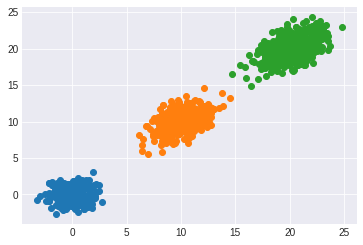

In [16]:
#三个颜色分别代表从三个高斯分布中抽样的样本
fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(s1[:,0],s1[:,1])
ax.scatter(s2[:,0],s2[:,1])
ax.scatter(s3[:,0],s3[:,1])
plt.show()

In [6]:
# 将所有点放进集合S中，此后我们不知道点与分布的对应情况
S=np.append(s1,s2,axis=0)
S=np.append(S,s3,axis=0)
S.shape

(1200, 2)

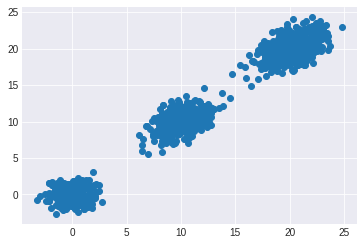

In [17]:
plt.scatter(S[:,0],S[:,1])

$
接下来我们用高斯混合模型对S中的点进行分类 \\
step 1:初始化参数\pi_1,\pi_2,\pi_3,\mu_1,\Sigma_1,\mu_2,\Sigma_2,\mu_3,\Sigma_3 \\
在初始化\Sigma时注意保证其正定
$

In [19]:
def init():
    pi_1,pi_2,pi_3=1/4,1/4,1/2
    mu_1,sigma_1 = np.array([0.0,0.0]),np.array([[1.0,0.0],[0.0,1.0]])
    mu_2,sigma_2 = np.array([5.0,5.0]),np.array([[1.0,0.0],[0.0,1.0]])
    mu_3,sigma_3 = np.array([10.0,10.0]),np.array([[1.0,0.0],[0.0,1.0]])
    pi=[pi_1,pi_2,pi_3]
    mu=[mu_1,mu_2,mu_3]
    sigma=[sigma_1,sigma_2,sigma_3]

    return pi,mu,sigma


$
接下来对参数进行更新 \\
\pi_j^{t+1} = \frac{\sum_{i=1}^{n}A_{i,j,t}}{n} (1) \\
\mu_j^{t+1} = \frac{\sum_{i=1}^{n}A_{i,j,t}X_i}{\sum_{i=1}^{n}A_{i,j,t}} (2) \\
\Sigma_j^{t+1} = \frac{\sum_{i=1}^{n}A_{i,j,t}(X_i-\mu_j^t)(X_i-\mu_j^t)^T}{\sum_{i=1}^{n}A_{i,j,t}} (3) \\
A_{i,j,t}= \frac{N_j(X_i|\mu_j^t,\Sigma_j^t)\pi_j^t}{\sum_{j=1}^{3}N_j(X_i|\mu_j^t,\Sigma_j^t)\pi_j^t} (4)
$

In [20]:
def step_once(S,pi,mu,sigma):
    n=len(S) #数据集大小
    #初始化更新后的pi,mu,sigma, 他们还需要在后面重新赋值
    pi_next=pi.copy()
    mu_next=mu.copy()
    sigma_next=sigma.copy()
    # 为j=1,2,3分别初始化A_1,A_2,A_3
    A_1 = np.zeros(n,dtype=np.float32)
    A_2 = np.zeros(n,dtype=np.float32)
    A_3 = np.zeros(n,dtype=np.float32)
    A = [A_1,A_2,A_3]
    #根据(4)重新初始化 A_1,A_2,A_3
    for j in range(3):
        for i,x in enumerate(S):
            A[j][i] = multivariate_normal(mu[j],sigma[j]).pdf(x)*pi[j]/ \
            (multivariate_normal(mu[0],sigma[0]).pdf(x)*pi[0]+ \
             multivariate_normal(mu[1],sigma[1]).pdf(x)*pi[1]+ \
             multivariate_normal(mu[2],sigma[2]).pdf(x)*pi[2])
        #print(A[j].shape)
    #根据(1),(2),(3)更新pi,mu,sigma
    for j in range(3):
        pi_next[j] = np.sum(A[j]) / n
        mu_next[j] = np.sum(A[j].reshape(n,-1) * S, axis=0) / np.sum(A[j])
        t=np.zeros((2,2)) #(3)中的分子, 需要重新赋值
        for i,x in enumerate(S):
            x=x.reshape(len(x),-1)
            mu_T=mu[j].reshape(len(mu[j]),-1)
            t += A[j][i]*(x-mu_T) @ (x-mu_T).T
        sigma_next[j] = t/np.sum(A[j])
    
    return pi_next,mu_next,sigma_next
    

In [21]:
pi,mu,sigma=init()
print(f'初始参数:\n pi={pi} \n mu={mu}\n sigma={sigma}')
pi,mu,sigma=step_once(S,pi,mu,sigma)
print(f'一次迭代后:\n pi[0]={pi[0]} \n pi[1]={pi[1]} \n pi[2]={pi[2]}')
print(f'mu[0]={mu[0]} \n mu[1]={mu[1]} \n mu[2]={mu[2]}')
print(f'sigma[0]=\n{sigma[0]} \n sigma[1]=\n{sigma[1]} \n sigma[2]\n={sigma[2]}')

初始参数:
 pi=[0.25, 0.25, 0.5] 
 mu=[array([0., 0.]), array([5., 5.]), array([10., 10.])]
 sigma=[array([[1., 0.],
       [0., 1.]]), array([[1., 0.],
       [0., 1.]]), array([[1., 0.],
       [0., 1.]])]
一次迭代后:
 pi[0]=0.24958460489908854 
 pi[1]=0.006214198668797811 
 pi[2]=0.7442012532552084
mu[0]=[-0.04037326 -0.07038119] 
 mu[1]=[6.60971679 6.47031509] 
 mu[2]=[15.75317742 15.69839144]
sigma[0]=
[[1.12251278e+00 5.81944574e-04]
 [5.81944574e-04 9.63229530e-01]] 
 sigma[1]=
[[4.67283943 3.23750323]
 [3.23750323 3.75172002]] 
 sigma[2]
=[[59.6422528  58.16869299]
 [58.16869299 58.79423617]]


In [22]:
def EM(S,pi,mu,sigma,iter_num):
    for i in range(iter_num):
        pi,mu,sigma = step_once(S,pi,mu,sigma)
        ''' 
        同学们可以去掉注释看看更新的过程
        if((i+1) % 10 == 0):
            print(f'{i+1}次迭代后：\n pi[0]={pi[0]} \n pi[1]={pi[1]} \n pi[2]={pi[2]}')
            print(f'mu[0]={mu[0]} \n mu[1]={mu[1]} \n mu[2]={mu[2]}')
            print(f'sigma[0]=\n{sigma[0]} \n sigma[1]=\n{sigma[1]} \n sigma[2]\n={sigma[2]}')
        '''
    return pi,mu,sigma


In [23]:
iter_num=20
pi,mu,sigma = init()
pi,mu,sigma=EM(S,pi,mu,sigma,iter_num)
print(f'{iter_num}次迭代后：')
print(f'mu[0]={mu[0]} \n mu[1]={mu[1]} \n mu[2]={mu[2]}')
print(f'sigma[0]=\n{sigma[0]} \n sigma[1]=\n{sigma[1]} \n sigma[2]\n={sigma[2]}')

20次迭代后：
mu[0]=[-0.03711534 -0.06517043] 
 mu[1]=[10.11951047 10.08229358] 
 mu[2]=[20.13778938 20.06648889]
sigma[0]=
[[1.12539988 0.00793965]
 [0.00793965 0.9730284 ]] 
 sigma[1]=
[[1.96418353 1.01009802]
 [1.01009802 1.93244014]] 
 sigma[2]
=[[2.30844513 1.16439587]
 [1.16439587 2.28993778]]


$
对比初始值可以发现两者已经非常接近了。\\
\mu_1=[0,0], \mu_2=[10,10] , \mu_3=[20,20],
\Sigma_1 =
\begin{pmatrix}
1&0 \\
0&1
\end{pmatrix},
\Sigma_2 =
\begin{pmatrix}
2&1 \\
1&2
\end{pmatrix},
\Sigma_3 =
\begin{pmatrix}
2&1 \\
1&2
\end{pmatrix} \\
获得了三个高斯分布的参数后我们就可以对样本进行分类: \\
对于样本X_i,我们分别计算p0=N_0(X_i|\mu_0,\Sigma_0),p1=N_1(X_i|\mu_1,\Sigma_1),p2=N_2(X_i|\mu_2,\Sigma_2)，若p_i最大，则样本被分为第i类.
$

In [13]:
# 把S中的样本点分类
C0=[]
C1=[]
C2=[]
C=[C0,C1,C2]
for x in S:
    p0 = multivariate_normal(mu[0],sigma[0]).pdf(x)
    p1 = multivariate_normal(mu[1],sigma[1]).pdf(x)
    p2 = multivariate_normal(mu[2],sigma[2]).pdf(x)
    cls = np.argsort([p0,p1,p2])[-1]  #cls:样本所属类别 0 or 1 or 2
    C[cls].append(list(x))

    

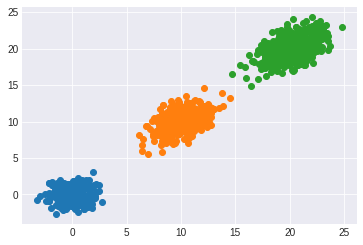

In [18]:
#可视化分类结果
fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(np.array(C0)[:,0],np.array(C0)[:,1])
ax.scatter(np.array(C1)[:,0],np.array(C1)[:,1])
ax.scatter(np.array(C2)[:,0],np.array(C2)[:,1])
plt.show()